### Imports

In [4]:
from tensorflow.keras.models import load_model
import pandas as pd
import pathlib
import tensorflow as tf
import os
import tensorflow.keras.applications     as     applications
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
sys.path.append('../utilities/')
from utilities import Timer, show_image, DreamImage, DeepDream, class_names, ProgressBar, plot_confusion_matrix

### Setup

In [4]:
sns.set()

AUTOTUNE = tf.data.experimental.AUTOTUNE

width = height = 224
batch_size = 32

### Load the Model

In [5]:
model_name = 'vgg19-INet-down2-b'
base_model = load_model(f'../classification/logs/models/{model_name}.hdf5')

# Remove dropout
model = Sequential()
for layer in base_model.layers:
    if isinstance(layer, Dropout):
        pass
    else:
        model.add(layer)

### Load the Data in Special Form

In [6]:
# Load the list of file names in the form of data_dir/class_name/file_name.jpg
data_subdir = 'test'
data_dir = pathlib.Path('../dataset/images/') / pathlib.Path(data_subdir)
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

dataset_size = len(list(list_ds))

In [7]:
# Function to get the label
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == class_names

# Function to get the image
def decode_img(file_path):
    # Load the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize
    return tf.image.resize(img, [width, height])

def preprocess_img(img, label, file_path):
    return applications.vgg19.preprocess_input(img), label, tf.convert_to_tensor(file_path)

In [8]:
# Combine both processes
def process_path(file_path):
    return decode_img(file_path), get_label(file_path), file_path

In [9]:
def classify_image(img_batch, label_batch, file_path_batch):
    return model(img_batch), label_batch, file_path_batch

In [10]:
# Create the dataset
ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
ds = ds.map(preprocess_img)
ds = ds.batch(batch_size).prefetch(buffer_size = AUTOTUNE)
ds = ds.map(classify_image)
ds = ds.cache()

### Do Predictions on the Dataset

In [11]:
bar = ProgressBar(dataset_size // batch_size + 1)

In [12]:
class_batches = []
label_batches = []
file_batches  = []
bar.start()
iterations = 0
for class_batch, label_batch, file_batch in ds:
    class_batches.append(class_batch)
    label_batches.append(label_batch)
    file_batches.append(file_batch)
    iterations+=1
    bar.update(iterations)

[==================================================] 92/92 7.0s per loop          


### Extract Predictions into a Convenient Numpy Array

In [33]:
# Convert to a single array
def concat_batches(batch_list):
    batch_list = [tensor.numpy() for tensor in batch_list]
    return np.concatenate(batch_list)

y_predict_proba = concat_batches(class_batches)
y_true          = concat_batches(label_batches)
file_paths      = concat_batches(file_batches)

In [34]:
# Get Hard Predictions
y_pred = []
for a in y_predict_proba:
    out = np.zeros(len(a))
    out[a.argmax()] = 1
    out = np.expand_dims(out, 0)
    y_pred.append(out)
y_pred = np.concatenate(y_pred)

In [35]:
# Get Predictions and True Values as Labels
y_pred_label = []
for a in y_predict_proba:
    out = class_names[a.argmax()]
    y_pred_label.append(out)

y_true_label = []
for a in y_true:
    out = class_names[a.argmax()]
    y_true_label.append(out)

In [36]:
file_df            = pd.Series(file_paths  , name = 'file')
y_pred_label       = pd.Series(y_pred_label, name = 'pred_label')
y_true_label       = pd.Series(y_true_label, name = 'true_label')

In [37]:
predict_df = pd.concat([file_df, y_pred_label, y_true_label], axis = 'columns')

In [42]:
y_predict_proba_df = pd.DataFrame(y_predict_proba, index = predict_df.index)
y_true_df          = pd.DataFrame(y_true         , index = predict_df.index)
y_pred_df          = pd.DataFrame(y_pred         , index = predict_df.index)

In [43]:
one_hot_df = [(y_predict_proba_df, 'predict_proba'),
              (y_true_df         , 'y_true')       ,
              (y_pred_df         , 'y_pred')
             ]

one_hot_df = [df.rename(lambda col : f'{name}_{col}', axis = 'columns') for df, name in one_hot_df]
one_hot_df = pd.concat(one_hot_df, axis = 'columns')

In [44]:
predict_df.to_csv('predictions.csv')
one_hot_df.to_csv('one_hot_predictions.csv')

### Examine Predictions

In [13]:
predict_df = pd.read_csv('predictions.csv', index_col = 0)
predict_df['file'] = predict_df.file.str.slice(2,-1)

In [10]:
# one_hot_df = pd.read_csv('one_hot_predictions.csv')

In [14]:
predict_df

,file,pred_label,true_label
0,../dataset/images/test/Mary Cassatt/72265.jpg,Mary Cassatt,Mary Cassatt
1,../dataset/images/test/Pablo Picasso/71123.jpg,Pablo Picasso,Pablo Picasso
2,../dataset/images/test/M.C. Escher/11212.jpg,Rene Magritte,M.C. Escher
3,../dataset/images/test/Salvador Dali/9640.jpg,Salvador Dali,Salvador Dali
4,../dataset/images/test/Egon Schiele/1611.jpg,Egon Schiele,Egon Schiele
...,...,...,...
2936,../dataset/images/test/Max Ernst/3672.jpg,Max Ernst,Max Ernst
2937,../dataset/images/test/James McNeill Whistler/...,William Turner,James McNeill Whistler
2938,../dataset/images/test/Pierre-Auguste Renoir/3...,Paul Cezanne,Pierre-Auguste Renoir
2939,../dataset/images/test/Pablo Picasso/75050.jpg,Amedeo Modigliani,Pablo Picasso


In [15]:
print(classification_report(predict_df.true_label, predict_df.pred_label))

                         precision    recall  f1-score   support

      Wassily Kandinsky       0.33      0.37      0.35        43
         Albrecht Durer       0.58      0.58      0.58       100
      Amedeo Modigliani       0.93      0.78      0.85        68
            Andy Warhol       0.26      0.30      0.28        37
           Claude Monet       0.73      0.72      0.72       100
             Cy Twombly       1.00      0.70      0.82        23
           Diego Rivera       0.43      0.38      0.41        26
        Diego Velazquez       0.23      0.26      0.25        27
            Edgar Degas       0.58      0.57      0.57        99
          Edouard Manet       0.19      0.24      0.21        46
           Edvard Munch       0.17      0.19      0.18        36
          Edward Hopper       0.71      0.38      0.49        32
           Egon Schiele       0.70      0.53      0.60        57
               El Greco       0.74      0.61      0.67        33
          Fernand Leger 

In [23]:
class_report = pd.DataFrame(classification_report(predict_df.true_label, predict_df.pred_label, output_dict = True)).transpose()
class_report.sort_values('f1-score', inplace = True)
class_report

,precision,recall,f1-score,support
Otto Dix,0.333333,0.041667,0.074074,24.000000
Edvard Munch,0.175000,0.194444,0.184211,36.000000
Sandro Botticelli,0.159091,0.269231,0.200000,26.000000
John Ruskin,0.285714,0.160000,0.205128,25.000000
Winslow Homer,0.500000,0.130435,0.206897,23.000000
Edouard Manet,0.189655,0.239130,0.211538,46.000000
Diego Velazquez,0.233333,0.259259,0.245614,27.000000
Andy Warhol,0.261905,0.297297,0.278481,37.000000
Gustav Klimt,0.380952,0.250000,0.301887,32.000000
James McNeill Whistler,0.400000,0.300000,0.342857,40.000000


In [ ]:
np.set_printoptions(threshold=np.inf)

cm = confusion_matrix(predict_df.true_label, predict_df.pred_label)
cm

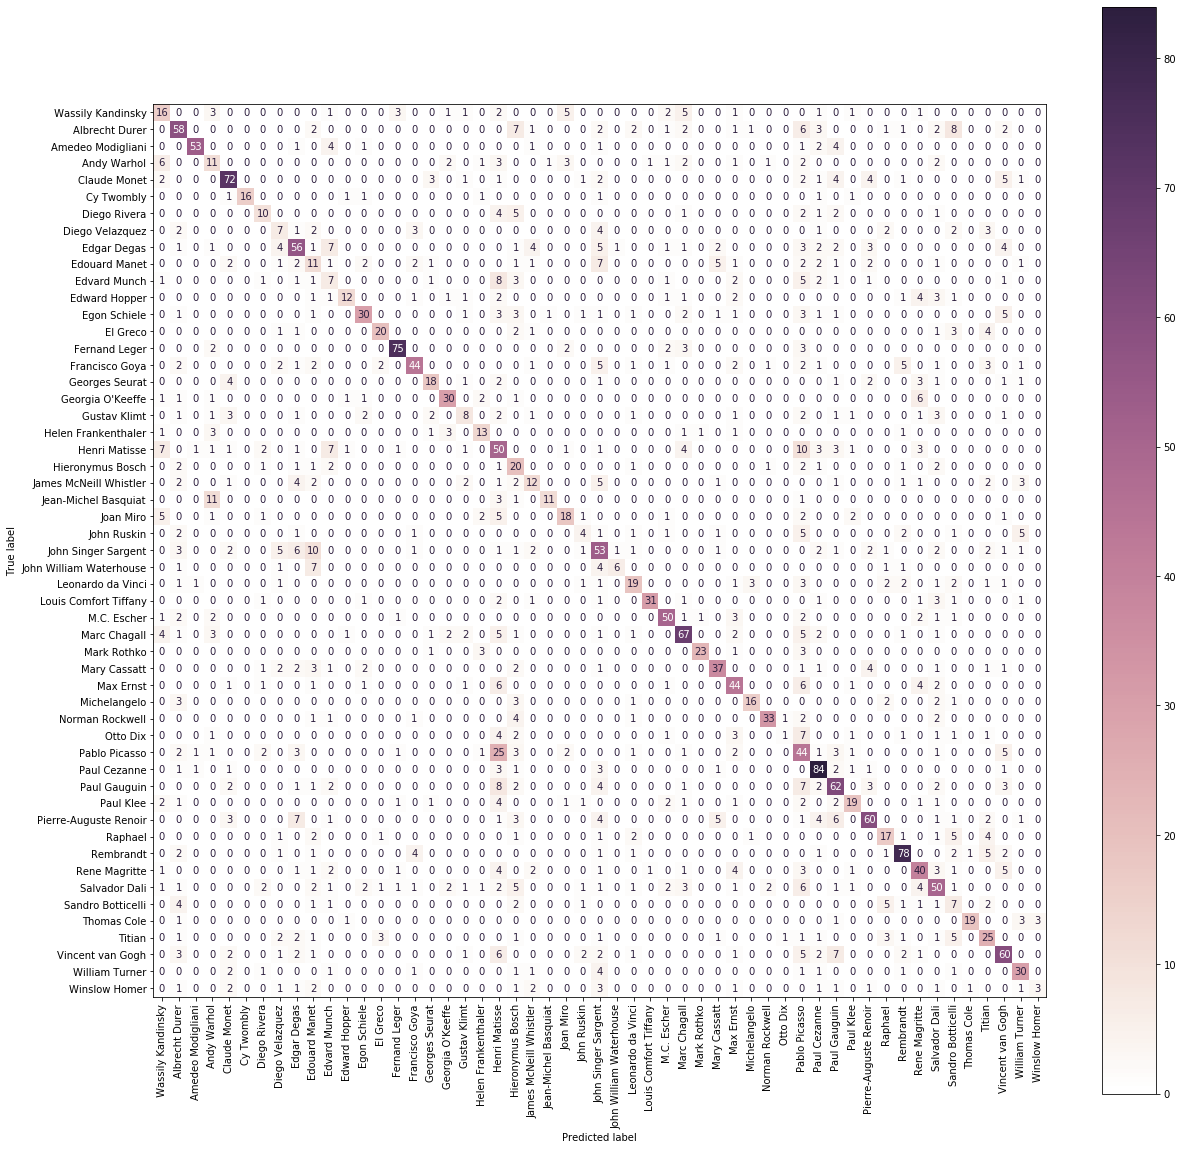

In [27]:
fig, ax = plt.subplots(figsize = (20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(include_values=True,
                 cmap=sns.cubehelix_palette(light=1, as_cmap=True), ax=ax, xticks_rotation='vertical')
fig.savefig('confusion_matrix.png', bbox = 'tight')
plt.show()

In [ ]:
predict_df[(predict_df.true_label == 'Pablo Picasso') & (predict_df.pred_label == 'Henri Matisse')].sort_values('file')

In [41]:
predict_df[(predict_df.true_label == 'Jean-Michel Basquiat') & (predict_df.pred_label == 'Andy Warhol')].sort_values('file').file.str.slice(-10, -4)

1217    102838
1952    /25659
1539    /33266
1810    /36294
273     t/6047
2152    t/6950
600     /78987
1479    /84765
182     /87367
1250    /90710
2190    /93352
Name: file, dtype: object